In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 16.1 MB/s 
     |████████████████████████████████| 6.6 MB 6.9 MB/s 
     |████████████████████████████████| 596 kB 12.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from transformers import pipeline,AutoTokenizer, AutoModelWithLMHead
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from transformers import BertForSequenceClassification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Spring 2022/IDS 576 Deep Learning and Applications (38063)/Project/KaggleRun_v2/TripAdvisor_US_data.csv')

**About T5:**
In contrast to BERT-style models, which can either output a class label or a 
span of the input, Google T5 Engine proposes reframing all NLP jobs into a 
unified text-to-text-format where the input and output are always text strings.

T5's text-to-text architecture allows users to apply the same model, 
loss function, and hyperparameters to any NLP application, such as 
machine translation, document summarization, question answering, and 
classification (e.g., sentiment analysis). 

T5 can also be used for regression problems if we teach it to predict the 
string representation of a number rather than the actual number.


**About Pretrained Model:**
The pretrained model used here is trained and fine tuned on a wide range of 
emotion dataset (https://github.com/dair-ai/emotion_dataset) to classify 6 
different emotions

1. sadness
2. joy
3. love
4. anger
5. fear
6. surprise

In [ ]:
# Function to detect emotion of a review
# ref: https://arxiv.org/pdf/1910.10683.pdf
# https://huggingface.co/mrm8488/t5-base-finetuned-emotion

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

def get_emotion(text):
    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt',max_length=512,truncation=True)
    output = model.generate(input_ids=input_ids,max_length=2)
    dec = [tokenizer.decode(ids) for ids in output]
    label = dec[0].split()[1]
    return label

# running batches for detecting emotion
a=60
loops = 30
step = 1373
start = 82380
for i in range(loops):
    res = df['ReviewText'][start:step+start].apply(lambda x: get_emotion(x))
    pickle.dump(res,open(f'emotion_data_part_{i+a}.pkl','wb'))
    start+=step
  

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:911: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:

fl = glob.glob('emotion_data_part_*')

emotions = []
for f in fl:
    emotions.extend(pickle.load(open(f,'rb')))

emot = pd.DataFrame({'ReviewID':df['ReviewID'],'emotion':emotions})
emot.to_csv('emotions_reviewID.csv')

In [ ]:
em_df = pd.read_csv('/content/drive/MyDrive/Spring 2022/IDS 576 Deep Learning and Applications (38063)/Project/KaggleRun_v2/emotions_reviewID.csv')

In [ ]:
def emot_to_index(x):
  if x in ['sadness','anger']:
    return 0
  elif x in ['fear','surprise']:
    return 1
  else:
    return 2

In [ ]:
df['emotion'] = em_df['emotion']
df['ReviewDate_dt'] = pd.to_datetime(df['ReviewDate'],errors='coerce')
df['ResponseDate'] = pd.to_datetime(df['ResponseDate'],errors='coerce')

df['ReviewDate_dt'] = df['ReviewDate_dt'].fillna(0)
df['ReviewDate_dt'] = df.apply(lambda x: dt.strptime(x['ReviewDate'],'%b %d').replace(year=x['ResponseDate'].year) if x['ReviewDate_dt'] == 0 else x['ReviewDate_dt'],axis=1)

df['DelayInResponse'] = (df['ResponseDate'] - df['ReviewDate_dt']).apply(lambda x: x.days)
df['ReviewStar'] = df['ReviewStar']//10
df['AverageScore'] = df[['ValueScore','ServiceScore','Sleep QualityScore','RoomsScore','LocationScore','CleanlinessScore']].mean(axis=1)//10

df.groupby('emotion')['DelayInResponse'].mean()

emotion
anger       31.549307
fear        29.909355
joy         31.044232
love        28.181356
sadness     29.691995
surprise    34.047191
Name: DelayInResponse, dtype: float64

It is observed that the average delay in responding to the reviews is same (1 month) irrespective of emotion.

In [ ]:
df['Index'] = df['emotion'].apply(lambda x : emot_to_index(x)) 
num_classes = len(df['Index'].unique())

```Index``` column is created with 3 levels of categories <br>
0 - High Criticality (Anger and Sadness) <br>
1 - Medium Criticality (Fear and Surprise) <br>
2 - Low Criticality (Happy and Joy)

The data is split into training and validation sets with 30% data in validation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.Index.values, 
                                                  test_size=0.3, 
                                                  random_state=213, 
                                                  stratify=df.Index.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

**About BERT base model**:
- Bidirectional Encoder Representations from Transformers is a transformer-based machine learning NLP model developed by Google

- It has 728 feed forward networks in the base version which is used here. It is pre-trained on massive corpus, English Wikipedia and can be utilized with minimal task-specific fine-tuning.

- We will train this model on a down-stream task to classify our reviews for predictions.


In [ ]:
# ref: https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/#s2-baseline-strategies
# ref: BERT - https://arxiv.org/abs/1810.04805
# ref: https://huggingface.co/bert-base-uncased

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].ReviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=256,
    truncation=True,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].Index.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].ReviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=256, 
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].Index.values)


dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_classes,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# creating torch dataloaders

batch_size = 16

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=RandomSampler(dataset_val), 
                                   batch_size=batch_size)

Model Parameters:
- learning rate: 1e-5, 2e-5
- Optimizer: AdamW
- Epochs: 10

In [ ]:
lr=1e-5

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
                  
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def preds_flat(preds):   
    preds_flat = np.argmax(preds, axis=1).flatten()
    return preds_flat

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for d in dataloader_val:
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        targets = d[2].to(device)
        
        with torch.no_grad(): 
            outputs = model(input_ids=input_ids,attention_mask=attention_mask,labels=targets,return_dict=True)
            
        loss = outputs.loss
        logits = outputs.logits
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = targets.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    

In [ ]:
import random

seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
    
hist = {'train':[],'val':[],'val_f1_score':[]}    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for d in progress_bar:

        model.zero_grad()
        
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        targets = d[2].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask,labels=targets,return_dict=True)
        
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(d))})
         
        
    torch.save(model.state_dict(), f'BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    hist['train'].append(loss_train_avg)
    hist['val'].append(val_loss)
    hist['val_f1_score'].append(val_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7252377257707359
Validation loss: 0.7200651390314823
F1 Score (Weighted): 0.5891856235991899


Epoch 2:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7230481552244313
Validation loss: 0.7206685580875939
F1 Score (Weighted): 0.5891856235991899


Epoch 3:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7214866414657908
Validation loss: 0.7221271506943577
F1 Score (Weighted): 0.5891856235991899


Epoch 4:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7111465927080458
Validation loss: 0.7386305260539929
F1 Score (Weighted): 0.5918975850504141


Epoch 5:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6688465798972648
Validation loss: 0.7848614750749138
F1 Score (Weighted): 0.6010753108081093


Epoch 6:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.6064967823922579
Validation loss: 0.8408105925632336
F1 Score (Weighted): 0.5999671695517319


Epoch 7:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.5439821062256454
Validation loss: 0.924860625687374
F1 Score (Weighted): 0.5956530542337776


Epoch 8:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.4887592768796451
Validation loss: 1.0378003914004057
F1 Score (Weighted): 0.5922082959772563


Epoch 9:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.4443549548561866
Validation loss: 1.1124656997559963
F1 Score (Weighted): 0.5888925868791987


Epoch 10:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.4118711572227955
Validation loss: 1.1647092217951691
F1 Score (Weighted): 0.5933427924702446


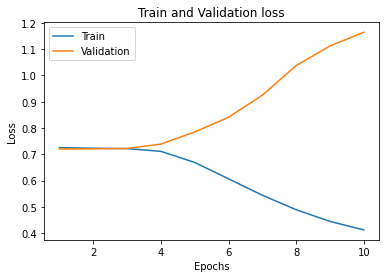

In [ ]:
sns.lineplot(x=range(1,epochs+1),y=hist['train'],label='Train')
sns.lineplot(x=range(1,epochs+1),y=hist['val'],label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation loss')
plt.show()

In [ ]:
lr = 2e-5

In [ ]:
import random

seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
    
hist = {'train':[],'val':[],'val_f1_score':[]}    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for d in progress_bar:

        model.zero_grad()
        
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        targets = d[2].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask,labels=targets,return_dict=True)
        
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(d))})
         
        
    torch.save(model.state_dict(), f'BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    hist['train'].append(loss_train_avg)
    hist['val'].append(val_loss)
    hist['val_f1_score'].append(val_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7245220756804147
Validation loss: 0.7204720373934695
F1 Score (Weighted): 0.5891856235991899


Epoch 2:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7216690741858334
Validation loss: 0.7202928985147884
F1 Score (Weighted): 0.5891856235991899


Epoch 3:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.720902912978745
Validation loss: 0.7229166788997247
F1 Score (Weighted): 0.5891856235991899


Epoch 4:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7209758906591969
Validation loss: 0.7213689081618433
F1 Score (Weighted): 0.5891856235991899


Epoch 5:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.7207820075253186
Validation loss: 0.7209518342296986
F1 Score (Weighted): 0.5891856235991899


Epoch 6:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.7205579983498002
Validation loss: 0.7206056942752481
F1 Score (Weighted): 0.5891856235991899


Epoch 7:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.7203373354564252
Validation loss: 0.7197825970400702
F1 Score (Weighted): 0.5891856235991899


Epoch 8:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.7202434874526759
Validation loss: 0.7212824591748612
F1 Score (Weighted): 0.5891856235991899


Epoch 9:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.7202864510362197
Validation loss: 0.7216918813961047
F1 Score (Weighted): 0.5891856235991899


Epoch 10:   0%|          | 0/5407 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.7202879252066912
Validation loss: 0.720651948405691
F1 Score (Weighted): 0.5891856235991899


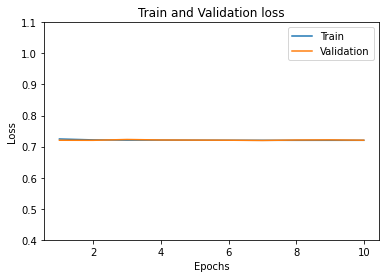

In [ ]:
sns.lineplot(x=range(1,epochs+1),y=hist['train'],label='Train')
sns.lineplot(x=range(1,epochs+1),y=hist['val'],label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.4,1.1])
plt.title('Train and Validation loss')
plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_classes,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Spring 2022/IDS 576 Deep Learning and Applications (38063)/Project/FinalRUn/lr1/BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)
preds = preds_flat(predictions)

In [ ]:
print(accuracy_score(preds,true_vals))

0.5296922122413747


In [ ]:
print(f1_score(preds,true_vals,average='weighted'))

0.5886929856472358


In [ ]:
def predict_test(text):

    encoded_data_test = tokenizer.batch_encode_plus(
        [text], 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        max_length=256, 
        truncation=True,
        return_tensors='pt'
    )

    input_ids_tst = encoded_data_test['input_ids']
    attention_masks_tst = encoded_data_test['attention_mask']

    dataset_test = TensorDataset(input_ids_tst, attention_masks_tst)
    dataloader_tst = DataLoader(dataset_test, 
                                      sampler=RandomSampler(dataset_test), 
                                      batch_size=batch_size)
    model.eval()
    
    loss_val_total = 0
    predictions = []
    
    for d in dataloader_tst:
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
                                         
        with torch.no_grad(): 
            outputs = model(input_ids=input_ids,attention_mask=attention_mask,return_dict=True)
            
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    dict_ = {0:'High Criticality',1:'Medium Criticality',2:'Low Criticality'}
    predictions = np.concatenate(predictions, axis=0)
    preds_flat = np.argmax(predictions, axis=1).flatten()[0]
    return dict_[preds_flat]


In [ ]:
txt = "Nice place to stay. Food was great. I would not hesitate to go back again"
predict_test(txt)

'Low Criticality'

In [ ]:
txt = 'Not many options are avaialble to eat. I am happy to see that atleast they provide dessert.' # misclassified
predict_test(txt)

'Low Criticality'

In [ ]:
txt = 'Hotel is not secure!.' 
predict_test(txt)

'Medium Criticality'

In [ ]:
txt = "I am surprised to see that they don't offer any starters" # misclassified
predict_test(txt)

'Low Criticality'

In [ ]:
txt = "Food is very bad. Never coming back here again"
predict_test(txt)

'High Criticality'